In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns; sns.set(style="white", font_scale=2)

import numpy as np
import pandas as pd
from astropy.io import fits
import glob

from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers.noise import GaussianNoise
from keras.utils import np_utils
from keras.constraints import maxnorm

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
K.set_image_data_format('channels_first')

import scipy.ndimage as ndi

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = np.array((10,6))*.6


Using TensorFlow backend.


In [2]:
# give access to importing dwarfz
import os, sys
dwarfz_package_dir = os.getcwd().split("dwarfz")[0]
if dwarfz_package_dir not in sys.path:
    sys.path.insert(0, dwarfz_package_dir)

import dwarfz
    
# back to regular import statements

# To Do
 1. Read in fits images
 2. Apply pre-processing stretch (asinh)
 3. crop image smaller
 4. Combine filters into one cube
 5. Create training set with labels
 6. Set up keras model
 7. Poke around at the results
 
 

# 0) Get files

In [3]:
images_dir = "../data/galaxy_images_training/quarry_files/"

In [4]:
HSC_ids = [int(os.path.basename(image_file).split("-")[0])
           for image_file in glob.glob(os.path.join(images_dir, "*.fits"))]
HSC_ids = set(HSC_ids) # remove duplicates
HSC_ids = np.array(sorted(HSC_ids))

# now filter out galaxies missing bands
HSC_ids = [HSC_id
           for HSC_id in HSC_ids
           if len(glob.glob(os.path.join(images_dir, "{}*.fits".format(str(HSC_id)))))==5]
HSC_ids = np.array(HSC_ids)

In [5]:
HSC_ids.size

1866

In [6]:
HSC_id = HSC_ids[1] # for when I need a single sample galaxy

In [7]:
bands = ["g", "r", "i", "z", "y"]

# 1) Read in fits image


In [8]:
def get_image(HSC_id, band, images_dir=images_dir):
    """Reads a single image from its fits file
    Inputs
    ------
        HSC_id : int
        band : str
            valid options: 'g', 'r', 'i' , 'z', 'y'
            case-insensitive
    """
    
    image_pattern = os.path.join(images_dir,"{}-cutout-HSC-{}*.fits".format(
        str(HSC_id),
        band.upper()))
    image_matches = glob.glob(image_pattern)
    
    if len(image_matches) == 0:
        raise FileNotFoundError("No files match: {}".format(image_pattern))
    elif len(image_matches) > 1:
        raise RuntimeError("Found too many files matching: {}".format(image_pattern))
        
    image_filename = image_matches[0]
    
    hdulist = fits.open(image_filename)
    image = hdulist[1].data
    flux_mag_0 = hdulist[0].header['FLUXMAG0']
    return image, flux_mag_0

image, flux_mag_0 = get_image(HSC_id, "g")
print("image size: {} x {}".format(*image.shape))
image

image size: 239 x 239


array([[-0.00146446,  0.02150147,  0.00693631, ...,  0.02792656,
        -0.02018547,  0.01850448],
       [-0.02519608,  0.00035813, -0.0455959 , ..., -0.00586783,
        -0.00882499,  0.01241659],
       [ 0.03936524,  0.00645859, -0.02110163, ...,  0.02997875,
         0.009456  ,  0.00591614],
       ..., 
       [-0.03543996,  0.04346127, -0.0372493 , ..., -0.0014411 ,
        -0.01001758,  0.03473332],
       [-0.01037648, -0.03287457,  0.04310744, ...,  0.02935715,
         0.02273993, -0.00532476],
       [-0.05991019, -0.08159582,  0.02607481, ...,  0.01012528,
         0.00453719, -0.00872836]], dtype=float32)

In [9]:
def image_plotter(image, reverse_cmap=False):
    cmap = "gray_r" if reverse_cmap else "gray"
    
    plt.imshow(image,
               cmap=plt.get_cmap(cmap)
               )
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())


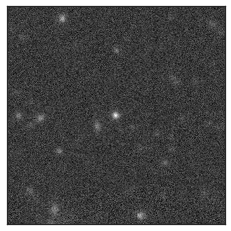

In [10]:
image_plotter(image)

/Users/egentry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


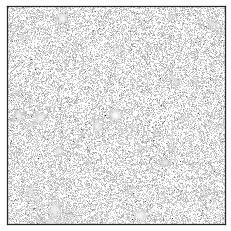

In [11]:
image_plotter(np.log(image))

# 2) Apply stretch

We're using (negative) asinh magnitudes, as implemented by the HSC collaboration.

To see more about asinh magnitude system, see : [Lupton, Gunn and Szalay (1999)](http://iopscience.iop.org/article/10.1086/301004/meta) used for SDSS. (It's expliticly given in the [SDSS Algorithms](http://classic.sdss.org/dr7/algorithms/fluxcal.html) documentation as well as [this overview page](https://ned.ipac.caltech.edu/help/sdss/dr6/photometry.html#asinh)).

To see the source of our code, see: [the HSC color image creator](https://hsc-gitlab.mtk.nao.ac.jp/snippets/23#L172)

And for reference, a common form of this stretch is:
$$ \mathrm{mag}_\mathrm{asinh} = - \left(\frac{2.5}{\ln(10)}\right) \left(\mathrm{asinh}\left(\frac{f/f_0}{2b}\right) + \ln(b) \right)$$
for dimensionless softening parameter $b$, and reference flux (f_0).


In [12]:
def scale(x, fluxMag0):
    ### adapted from https://hsc-gitlab.mtk.nao.ac.jp/snippets/23
    mag0 = 19
    scale = 10 ** (0.4 * mag0) / fluxMag0
    x *= scale

    u_min = -0.05
    u_max = 2. / 3.
    u_a = np.exp(10.)

    x = np.arcsinh(u_a*x) / np.arcsinh(u_a)
    x = (x - u_min) / (u_max - u_min)

    return x


In [13]:
image_scaled = scale(image, flux_mag_0)

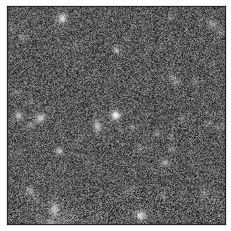

In [14]:
image_plotter(image_scaled)

Text(0.5,1,'Distribution of Transformed Intensities')

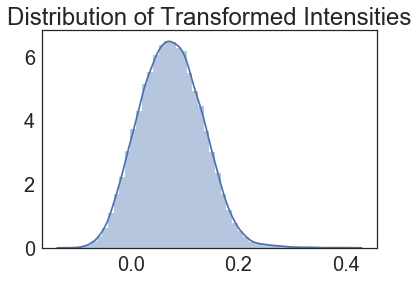

In [15]:
sns.distplot(image_scaled.flatten())
plt.title("Distribution of Transformed Intensities")

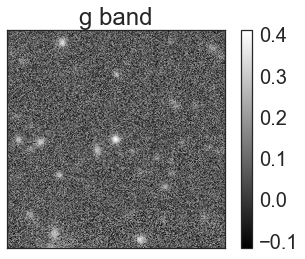

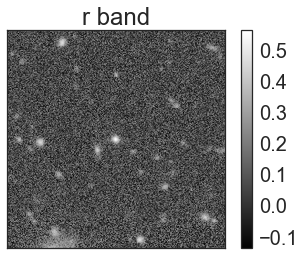

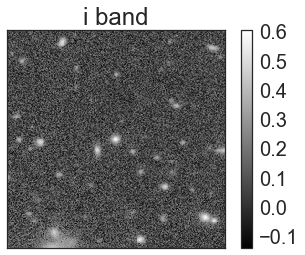

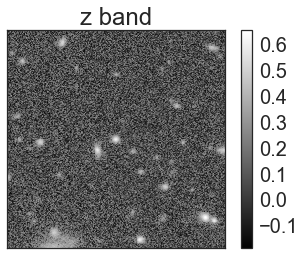

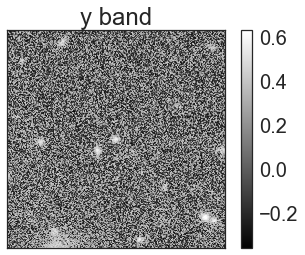

In [16]:
for band in bands:
    image, flux_mag_0 = get_image(HSC_id, band)
    image_scaled = scale(image, flux_mag_0)

    plt.figure()
    image_plotter(image_scaled)
    plt.title("{} band".format(band))
    plt.colorbar()

# 3) Crop Image
Am I properly handling odd numbers?

In [17]:
pre_transformed_image_size  = 100
post_transformed_image_size = 50

In [18]:
def get_cutout(image, cutout_size):
    """Takes an image, and cuts it down to `cutout_size x cutout_size`
    It only affects the final two dimensions of the array, so
    you can easily deal with multiple images / multiple channels
    simply by setting up the array with shape (n_channels, height, width)
    
    Inputs
    ------
    image : np.ndarray (ndim >= 2)
    cutout_size : int
        the [maximum] number of pixels you want in each dimension
        of the final image.



    Notes
    -----
    If `cutout_size` is large than an image dimension, it'll silently
    keep *the entire* range of that dimension. This won't have any 
    side-effects on the other dimension of non-square images.
"""
    image_shape = image.shape[-2:]

    center_index = (image_shape[0]//2, image_shape[1]//2)

    # Check that these are actually x and y ordered
    min_x = center_index[0] - (cutout_size//2)
    max_x = center_index[0] + (cutout_size//2)
    min_y = center_index[1] - (cutout_size//2)
    max_y = center_index[1] + (cutout_size//2)

    cutout = image[..., min_x:max_x, min_y:max_y]
    
    return cutout


In [19]:
cutout = get_cutout(image_scaled, post_transformed_image_size)
cutout.shape

(50, 50)

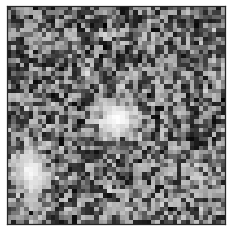

In [20]:
image_plotter(cutout)

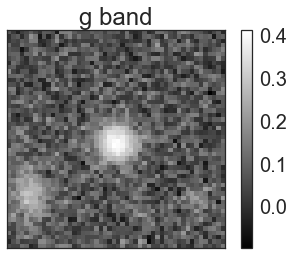

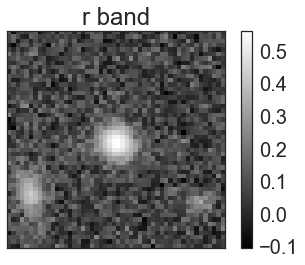

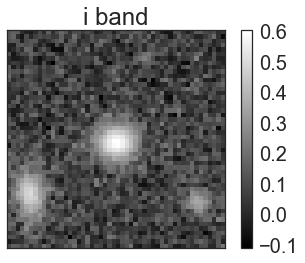

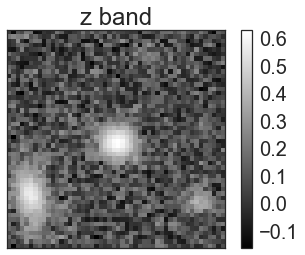

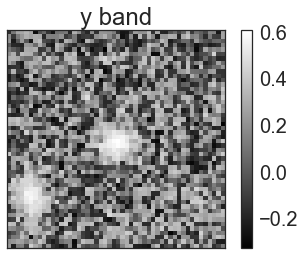

In [21]:
for band in bands:
    image, flux_mag_0 = get_image(HSC_id, band)
    image_scaled = scale(image, flux_mag_0)
    cutout = get_cutout(image_scaled, post_transformed_image_size)

    plt.figure()
    image_plotter(cutout)
    plt.title("{} band".format(band))
    plt.colorbar()

# 4) Combine filters into cube

In [22]:
images = [None]*len(bands)
flux_mag_0s = [None]*len(bands)
cutouts = [None]*len(bands)
for i, band in enumerate(bands):
    images[i], flux_mag_0s[i] = get_image(HSC_id, band)
    
    cutouts[i] = get_cutout(scale(images[i], flux_mag_0s[i]), post_transformed_image_size)

In [23]:
cutout_cube = np.array(cutouts)
cutout_cube.shape

(5, 50, 50)

In [24]:
def transform_0_1(X):
    return (X - X.min())/(X.max() - X.min())

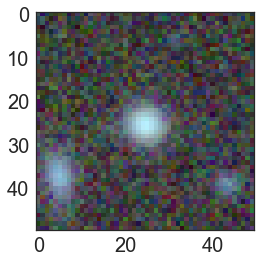

In [25]:
# must transform into [0,1] for plt.imshow
# the HSC standard tool accomplishes this by clipping instead.
plt.imshow(transform_0_1(cutout_cube[:3,:,:].transpose(1,2,0)) )

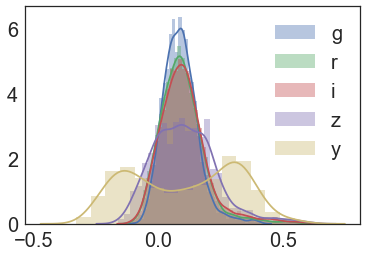

In [26]:
for i, band in enumerate(bands):
    sns.distplot(cutout_cube[:,:,:].transpose(1,2,0)[:,:,i].flatten(), label=band)
    plt.legend(loc="best")

# 5) Load Training Set Labels

In [27]:
training_set_labels_filename = "../data/galaxy_images_training/2017_09_26-dwarf_galaxy_scores.csv"

In [28]:
df = pd.read_csv(training_set_labels_filename)
df = df.drop_duplicates("HSC_id")
df = df.set_index("HSC_id")
df = df[["low_z_low_mass"]]
df = df.rename(columns={"low_z_low_mass":"target"})
df.head()

,target
HSC_id,
43158322471244656,False
43158605939114836,False
43159142810013665,False
43158734788125011,False
43158863637144621,True


In [29]:
from multiprocessing.pool import Pool
pool = Pool(6)

def load_image_mappable(HSC_id):
    images      = [None]*len(bands)
    flux_mag_0s = [None]*len(bands)
    cutouts     = [None]*len(bands)
    for j, band in enumerate(bands):
        images[j], flux_mag_0s[j] = get_image(HSC_id, band)
        cutouts[j] = get_cutout(scale(images[j], flux_mag_0s[j]), pre_transformed_image_size)
    cutout_cube = np.array(cutouts)
    return cutout_cube


Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/egentry/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/egentry/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/egentry/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/egentry/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/egentry/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/egentry/anaconda3/lib/python3.6/multiprocess

In [32]:
X = np.empty((len(HSC_ids), 5, 
              pre_transformed_image_size, pre_transformed_image_size))

*** **Note**, this might fail, with the error messages accidentally getting piped to the cell containing the `pool` instantiation. At this point you might need to interrupt kernel execution `Kernel > Interrupt` and then run the cells below.

In [37]:
X = np.array(pool.map(load_image_mappable, HSC_ids))

In [ ]:
# %%timeit -r 1 -n 1
# X = np.array(pool.map(load_image_mappable, HSC_ids))

In [38]:
X.shape

(1866, 5, 100, 100)

In [39]:
Y = df.loc[HSC_ids].target.values
Y

array([False, False,  True, ..., False, False, False], dtype=bool)

In [40]:
Y.mean()

0.27920685959271169

# Geometry!

In [41]:
def get_translation_matrix(dx, dy):
    """Get the affine transformation matrix for a translation (shift)
    
    Inputs
    ------
    dx : numeric
        how many pixels to shift the image in x (can be fractional)
    dy : numeric
        how many pixels to shift the image in y (can be fractional) 

    Returns
    -------
    translation_matrix : np.ndarray (shape 3x3, dtype=float)
        a transformed version of `matrix` account for the centering shifts
        
    Notes
    -----
    To apply *after* another matrix, you should do:
        `np.dot(other_matrix, translation_matrix)`
    """
    translation_matrix = np.array([[1, 0, -dy], [0, 1, -dx], [0, 0, 1]])
    return translation_matrix


def transform_matrix_offset_center(matrix, x, y):
    """Takes a transformation matrix (e.g. rotation) and adjusts it
    so that the image center is at the origin before the transformation,
    and then shifts it back after the center.
    
    Inputs
    ------
    matrix : np.ndarray (shape 3x3, dtype=float)
        a matrix defining an affine transformation
    x : numeric
        size of image in axis 0 (width)
    y : numeric
        size of image in axis 1 (height)

    Returns
    -------
    transform_matrix : np.ndarray (shape 3x3, dtype=float)
        a transformed version of `matrix` account for the centering shifts

    """
    o_x = float(x) / 2 - .5
    o_y = float(y) / 2 - .5
    offset_matrix = get_translation_matrix(-o_x, -o_y)
    reset_matrix = get_translation_matrix(o_x, o_y)
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix
    
def get_reflection_matrix(axis):
    """Get the affine transform matrix for a reflection about the origin
    for a specific axis
    
    Inputs
    ------
    axis : Optional(integer)
        the axis that you want flipped
        
    Returns
    -------
    reflection_matrix : np.ndarray (shape 3x3, dtype=int)
    
    Notes
    -----
    see `keras.preprocessing.image.flip_axis()` for alternative
    """
    if axis == 0:
        reflection_matrix = np.diag((-1, 1, 1))
    elif axis==1:
        reflection_matrix = np.diag((1, -1, 1))
    else:
        raise ValueError("`axis` must be 0 or 1, not {}".format(axis))
                
    return reflection_matrix

def get_centered_reflection_matrix(axis, h, w):
    """Get the affine transform matrix for a reflection about the image center
    for a specific axis
    
    Inputs
    ------
    axis : Optional(integer)
        the axis that you want flipped
    x : numeric
        size of image in axis 0 (width)
    y : numeric
        size of image in axis 1 (height)
        
    Returns
    -------
    centered_reflection_matrix : np.ndarray (shape 3x3, dtype=int)
    
    Notes
    -----
    see `keras.preprocessing.image.flip_axis()` for alternative
    """
    reflection_matrix = get_reflection_matrix(axis)
        
    centered_reflection_matrix = transform_matrix_offset_center(reflection_matrix, w, h)
        
    return centered_reflection_matrix


def get_rotation_matrix(rotation_degrees):
    """Get the affine transform matrix for a rotation about the origin
    
    Inputs
    ------
    rotation_degrees: numeric
        Rotation angle, in degrees, clockwise
    
    Returns
    -------
    rotation_matrix : np.ndarray (shape 3x3, dtype=float)
        affine transform matrix
    """
    theta = (np.pi / 180) * rotation_degrees # convert to radians
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta),  np.cos(theta), 0],
                                [0,              0,             1]])
    
    return rotation_matrix

def get_centered_rotation_matrix(rotation_degrees, h, w):
    """Get the affine transform matrix for a rotation about the image center
    
    Inputs
    ------
    rotation_degrees: numeric
        Rotation angle, in degrees, clockwise
    h : int
        height of image, in pixels (axis=0)
    w : int
        width of image, in pixels (axis=1)
    
    Returns
    -------
    centered_rotation_matrix : np.ndarray (shape 3x3, dtype=float)
        affine transform matrix
    """
    rotation_matrix = get_rotation_matrix(rotation_degrees)
    centered_rotation_matrix = transform_matrix_offset_center(rotation_matrix, w, h)
    
    return centered_rotation_matrix

def get_shear_matrix(shear_degrees):
    """Get the affine transform matrix for a shear w.r.t the origin
    
    Inputs
    ------
    shear_degrees: numeric
        shear angle, in degrees, clockwise
    
    Returns
    -------
    shear_matrix : np.ndarray (shape 3x3, dtype=float)
        affine transform matrix
    """
    theta = (np.pi / 180) * shear_degrees # convert to radians
    
    shear_matrix = np.array([[1, -np.sin(theta), 0],
                            [0,   np.cos(theta), 0],
                            [0,   0,             1]])
     
    return shear_matrix


def get_centered_shear_matrix(shear_degrees, h, w):
    """Get the affine transform matrix for a shear w.r.t the image center
    
    Inputs
    ------
    shear_degrees: numeric
        shear angle, in degrees, clockwise
    h : int
        height of image, in pixels (axis=0)
    w : int
        width of image, in pixels (axis=1)
    
    Returns
    -------
    centered_shear_matrix : np.ndarray (shape 3x3, dtype=float)
        affine transform matrix
    """    
    shear_matrix = get_shear_matrix(shear_degrees)
    centered_shear_matrix = transform_matrix_offset_center(shear_matrix, w, h)

    return centered_shear_matrix


def get_zoom_matrix(zoom_x, zoom_y):
    """Get the affine transform matrix for a zoom centered on the origin
    
    Inputs
    ------
    zoom_x: numeric
        zoom in on the x axis by a factor of zoom_x
    zoom_y: numeric
        zoom in on the x axis by a factor of zoom_x
    
    Returns
    -------
    zoom_matrix : np.ndarray (shape 3x3, dtype=float)
        affine transform matrix
    """    
    zoom_matrix = np.array([[zoom_y, 0,      0],
                            [0,      zoom_x, 0],
                            [0,      0,      1]])
    
    return zoom_matrix

def get_centered_zoom_matrix(zoom_x, zoom_y, h, w):
    """Get the affine transform matrix for a zoom centered on image center
    
    Inputs
    ------
    zoom_x: numeric
        zoom in on the x axis by a factor of zoom_x
    zoom_y: numeric
        zoom in on the x axis by a factor of zoom_x
    h : int
        height of image, in pixels (axis=0)
    w : int
        width of image, in pixels (axis=1)
    
    Returns
    -------
    centered_zoom_matrix : np.ndarray (shape 3x3, dtype=float)
        affine transform matrix
    """    
    zoom_matrix = get_zoom_matrix(zoom_x, zoom_y)
    centered_zoom_matrix = transform_matrix_offset_center(zoom_matrix, w, h)

    return centered_zoom_matrix


from keras.preprocessing.image import random_channel_shift, apply_transform


In [42]:
def get_full_transform(
    h, w,
    reflect_x = False,
    reflect_y = False,
    rotation_degrees = 0,
    translate_dx = 0,
    translate_dy = 0,
    shear_degrees = 0,
    zoom_x = 1,
    zoom_y = 1,
    ):
    """Get the combined affine transform matrix for reflection, rotation and translation
    
    Inputs
    ------
    h : int
        height of the image (axis=0)
    w : int
        width of the image (axis=1)
    reflect_x : Optional(bool)
    reflect_y : Optional(bool)
    rotation_degrees : Optional(numeric)
        rotation angle (clockwise) after reflection
    translate_dx : Optional(numeric)
        number of pixels to shift in x after reflection and rotation 
        (can be fractional)
    translate_dy : Optional(numeric)
        number of pixels to shift in y after reflection and rotation 
        (can be fractional)
    shear_degrees : Optional(numeric)
    zoom_x : Optional(numeric)
    zoom_y : Optional(numeric)

        
        
    Returns
    -------
    centered_transform_matrix : np.ndarray (shape 3x3, numeric)
        the matrix defining the affine transform
    """

    transform_matrix = np.eye(3, dtype=int)
    
    if reflect_x:
        reflection_matrix_x = get_reflection_matrix(1)
        transform_matrix = np.dot(transform_matrix, reflection_matrix_x)

    if reflect_y:
        reflection_matrix_y = get_reflection_matrix(0)
        transform_matrix = np.dot(transform_matrix, reflection_matrix_y)
        
    if rotation_degrees not in (0, 360):
        rotation_matrix = get_rotation_matrix(rotation_degrees)
        transform_matrix = np.dot(transform_matrix, rotation_matrix)
    
    if (translate_dx != 0) or (translate_dy != 0):
        # should this be at this point, or after I apply the shear + zoom?
        translation_matrix = get_translation_matrix(translate_dx, translate_dy)
        transform_matrix = np.dot(transform_matrix, translation_matrix)
    
    if shear_degrees != 0:
        shear_matrix = get_shear_matrix(shear_degrees)
        transform_matrix = np.dot(transform_matrix, shear_matrix)
    
    if (zoom_x != 1) or (zoom_y != 1):
        zoom_matrix = get_zoom_matrix(zoom_x, zoom_y)
        transform_matrix = np.dot(transform_matrix, zoom_matrix)
        
    if not (transform_matrix == np.eye(3)).all():
        centered_transform_matrix = transform_matrix_offset_center(transform_matrix, w, h)
    else:
        centered_transform_matrix = np.eye(3)
    
    return centered_transform_matrix
    
def create_random_transform_matrix(h, w,
                                   include_reflection=True,
                                   include_rotation=True,
                                   translation_size=0.0,
                                   seed=None,
                                   verbose=False,
                                  ):
    """Create a random transformation matrix
    Inputs
    ------
    h : int
        height of the image (axis=0)
    w : int
        width of the image (axis=1)
    include_reflection : Optional(bool)
        only includes an initial flip of the x-axis
        Assumes flip ~ Bernoulli(p=0.5)
    include_rotation : Optional(bool)
        Assumes rotation angle ~ Uniform(0, 360) degrees
    translation_size : Optional(float)
        Fraction of the image that the image can be translated
        Assumes translation[axis=i] ~ Uniform[-translation_size*shape[i], +translation_size*shape[i]]
    seed : Optional(int or None)
        random seed, or None if unseeded
    verbose : Optional(bool)
        
    Returns
    -------
    transfrom_matrix : np.ndarray (shape 3x3, numeric)
        the matrix defining the affine transform
    """
    np.random.seed(seed)
    
    if include_reflection:
        reflect_x = np.random.choice((True, False))
        reflect_y = np.random.choice((True, False))
    else:
        reflect_x = False
        reflect_y = False
    
    if include_rotation:
        rotation_degrees = np.random.random()*360
    else:
        rotation_degrees = 0
        
        
    translation_dx = (np.random.random() - 0.5) * 2 * translation_size * w
    translation_dy = (np.random.random() - 0.5) * 2 * translation_size * h

    
    if verbose:
        print("reflection axis = {}".format(reflection_axis))
        print("rotation angle = {:.1f}°".format(rotation_degrees))
        print("translation = ({:.1f}, {:.1f}) px".format(translation_dx,
                                                         translation_dy,))
        
    transform_matrix = get_full_transform(h, w,
                                          reflect_x = reflect_x,
                                          reflect_y = reflect_y,
                                          rotation_degrees = rotation_degrees,
                                          translate_dx = translation_dx,
                                          translate_dy = translation_dy,
                                         )
    
    return transform_matrix
    

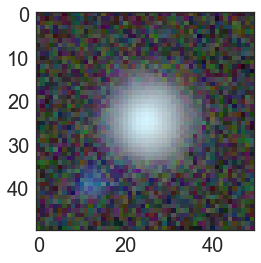

In [43]:
h = pre_transformed_image_size
w = pre_transformed_image_size
transform_matrix = create_random_transform_matrix(h, w,
                                                  include_rotation=True,
                                                  translation_size = .01,
                                                  verbose=False)

x_tmp = X[0][:3]

result = apply_transform(x_tmp, transform_matrix, 
                            channel_axis=0, fill_mode="constant", cval=np.max(x_tmp))

result = get_cutout(x_tmp, post_transformed_image_size)
plt.imshow(transform_0_1(result.transpose(1,2,0)))

In [44]:
def transform_plotter(
    reflect_x = False,
    rotation_degrees=45, 
    dx_after = 0,
    dy_after = 0,
    shear_degrees=0,
    zoom_x = 1,
    crop=False,
    color=True,
):

    x_tmp = X[0].copy()
    h, w = x_tmp.shape[1], x_tmp.shape[2]
    
    transform_matrix = get_full_transform(h, w,
                                          reflect_x=reflect_x,
                                          rotation_degrees=rotation_degrees,
                                          translate_dx=dx_after,
                                          translate_dy=dy_after,
                                          shear_degrees=shear_degrees,
                                          zoom_x = zoom_x,
                                         )
    

    x_tmp = x_tmp[0:3]

    result = apply_transform(x_tmp, transform_matrix, 
                            channel_axis=0, fill_mode="constant", cval=np.max(x_tmp))

    if crop:
        result = np.array([get_cutout(channel, channel.shape[0]//2)
                           for channel in result])

    with mpl.rc_context(rc={"figure.figsize": (10,6)}):
        if color:
            plt.imshow(transform_0_1(result.transpose(1,2,0)))
        else:
            plt.imshow(result[0], 
                       cmap=plt.get_cmap("viridis"),
                       vmin=0, vmax=np.max(x_tmp[0]),
                       )

import ipywidgets
ipywidgets.interact(transform_plotter,
                    rotation_degrees = ipywidgets.IntSlider(min=0, max=360, step=15, value=45),
                    dx_after = ipywidgets.IntSlider(min=-15, max=15),
                    dy_after = ipywidgets.IntSlider(min=-15, max=15),
                    color = ipywidgets.fixed(True),
                    shear_degrees = ipywidgets.IntSlider(min=0, max=90, step=5, value=0),
                    zoom_x = ipywidgets.FloatSlider(min=.5, max=2, value=1),
                    )

interactive(children=(Checkbox(value=False, description='reflect_x'), IntSlider(value=45, description='rotation_degrees', max=360, step=15), IntSlider(value=0, description='dx_after', max=15, min=-15), IntSlider(value=0, description='dy_after', max=15, min=-15), IntSlider(value=0, description='shear_degrees', max=90, step=5), FloatSlider(value=1.0, description='zoom_x', max=2.0, min=0.5), Checkbox(value=False, description='crop'), Output()), _dom_classes=('widget-interact',))

<function __main__.transform_plotter>

## 5b) Split training and testing set

In [45]:
randomized_indices = np.arange(X.shape[0])
np.random.shuffle(randomized_indices)

testing_fraction = 0.2
testing_set_indices = randomized_indices[:int(testing_fraction*X.shape[0])]
training_set_indices = np.array(list(set([*randomized_indices]) - set([*testing_set_indices])))

In [46]:
testing_set_indices.size

373

In [47]:
training_set_indices.size

1493

## 6b) Adapt NumpyArrayIterator
The original only allowed 1, 3 or 4 channel images. I have 5 channel images.

Also, I want to change the way that augmentation is happening

In [48]:
from keras.preprocessing.image import Iterator

class ArrayIterator(Iterator):
    """Iterator yielding data from a Numpy array.
    Builds on keras.preprocessing.image.NumpyArrayIterator
    but does not directly subclass
    
    Inputs
    ------
    x: Numpy array of input data 
        if `channels_first`, then shape N_img x N_channels x height x width
        if `channels_last`,  then shape N_img x height x width x N_channels

    y: Numpy array of targets data
        image_data_generator: Instance of `ImageDataGenerator`
            to use for random transformations and normalization.
    batch_size: Integer, size of a batch.
    shuffle: Boolean, whether to shuffle the data between epochs.
    seed: Random seed for data shuffling.
    output_image_shape: None, or list/tuple
        if list/tuple, should have ndim=2, of (height x width)
        if None, defaults to input image shape
    data_format: String, one of `channels_first`, `channels_last`.
    save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if `save_to_dir` is set).
        save_format: Format to use for saving sample images
            (if `save_to_dir` is set).
    """

    def __init__(self, x, y, image_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 output_image_shape=None,
                 data_format=None,
                 save_to_dir=None, save_prefix='', save_format='png'):
        if y is not None and len(x) != len(y):
            raise ValueError('X (images tensor) and y (labels) '
                             'should have the same length. '
                             'Found: X.shape = %s, y.shape = %s' %
                             (np.asarray(x).shape, np.asarray(y).shape))

        if data_format is None:
            data_format = K.image_data_format()
        self.x = np.asarray(x, dtype=K.floatx())

        if self.x.ndim != 4:
            raise ValueError('Input data in `ArrayIterator` '
                             'should have rank 4. You passed an array '
                             'with shape', self.x.shape)
        channels_axis = 3 if data_format == 'channels_last' else 1
        self.channels_axis = channels_axis

        if y is not None:
            self.y = np.asarray(y)
        else:
            self.y = None
        self.image_data_generator = image_data_generator
        self.output_image_shape = output_image_shape
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(ArrayIterator, self).__init__(x.shape[0], batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        batch_shape = [None]*4
        batch_shape[0] = len(index_array)
        batch_shape[self.channels_axis] = self.x.shape[self.channels_axis]
        image_axes = (2,3) if self.channels_axis==1 else (3,4)
        if self.output_image_shape is None:
            for image_axis in image_axes:
                batch_shape[image_axis] = self.x.shape[image_axis]
        else:
            for i, image_axis in enumerate(image_axes):
                batch_shape[image_axis] = self.output_image_shape[i]
                        
        batch_x = np.zeros(batch_shape,
                           dtype=K.floatx())
        for i, j in enumerate(index_array):
            x = self.x[j]
            x = self.image_data_generator.random_transform(x.astype(K.floatx()))
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
        if self.save_to_dir:
            for i, j in enumerate(index_array):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=j,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        if self.y is None:
            return batch_x
        batch_y = self.y[index_array]
        return batch_x, batch_y


## 6c) Adapt ImageDataGenerator
The original only allowed 1, 3 or 4 channel images. I have 5 channel images. Also, I'm adjusting the way that the affine transformations work for the data augmentation

In [49]:
class ImageDataGenerator(object):
    """Generate minibatches of image data with real-time data augmentation.
    This is adapted from `keras.preprocessing.image.ImageDataGenerator`
    but is not a direct subclass.
    
    Major differences:
        - accepts images with arbitrary number of channels, not just 1, 3 or 4
        - uses my custom data augmentation. In particular I start with a large image,
          apply desired transformations, then crop the image to a smaller size.
          This allows me to better deal with out-of-bounds issues with transformations,
          without needing to rely on things like `fill_mode`

    # Arguments
        featurewise_center: set input mean to 0 over the dataset.
        samplewise_center: set each sample mean to 0.
        featurewise_std_normalization: divide inputs by std of the dataset.
        samplewise_std_normalization: divide each input by its std.
        zca_whitening: apply ZCA whitening.
        zca_epsilon: epsilon for ZCA whitening. Default is 1e-6.
        with_reflection_x: boolean
            whether to randomly flip images horizontally before other transformations.
        with_reflection_y: boolean
            whether to randomly flip images vertically before other transformations.
        with_rotation: boolean
            whether to rotate the image randomly (after reflection, before translation)
        width_shift_range: fraction of total width. Shift will be randomly 
            chosen within +/- this range. (translation applied after rotation)
        height_shift_range: fraction of total height. Shift will be randomly 
            chosen within +/- this range. (translation applied after rotation)
        shear_range: shear intensity (shear angle in degrees).
        zoom_range: amount of zoom. if scalar z, zoom will be randomly picked
            in the range [z**-1, z]. A sequence of two can be passed instead
            to select this range.
        channel_shift_range: shift range for each channel.
            (shifts all values up by a constant, while clipping to the original min/max)
        fill_mode: points outside the boundaries are filled according to the
            given mode ('constant', 'nearest', 'reflect' or 'wrap'). Default
            is 'constant'.
        cval: value used for points outside the boundaries when fill_mode is
            'constant'. Default is 0.
        rescale: rescaling factor. If None or 0, no rescaling is applied to
            the pixel values, otherwise we multiply the data by the value 
            provided. This is applied after the `preprocessing_function` 
            (if any provided) but before any other transformation.
        preprocessing_function: function that will be implied on each input.
            The function will run *before* any pixel-wise modification on it,
            but after affine transformations/channel-wise shifts.
            The function should take one argument:
            one image (Numpy tensor with rank 3),
            and should output a Numpy tensor with the same shape.
        postprocessing_function: function that will be implied on each input.
            The function will run *after* all other modifications and transformations.
            The function should take one argument:
            one image (Numpy tensor with rank 3),
            and *can* output a Numpy tensor with *a different shape*.
        output_image_shape: None, or list/tuple
            if list/tuple, should have ndim=2, of (height x width)
            if None, defaults to input image shape
        data_format: 'channels_first' or 'channels_last'. In 'channels_first' mode, the channels dimension
            (the depth) is at index 1, in 'channels_last' mode it is at index 3.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
    """

    def __init__(self,
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 zca_epsilon=1e-6,
                 with_reflection_x=False,
                 with_reflection_y=False,
                 with_rotation=False,
                 width_shift_range=0.,
                 height_shift_range=0.,
                 shear_range=0,
                 zoom_range=1,
                 channel_shift_range=0,
                 fill_mode='constant',
                 cval=0.,
                 rescale=None,
                 preprocessing_function=None,
                 postprocessing_function=None,
                 output_image_shape=None,
                 data_format=None):
        if data_format is None:
            data_format = K.image_data_format()
        self.featurewise_center = featurewise_center
        self.samplewise_center = samplewise_center
        self.featurewise_std_normalization = featurewise_std_normalization
        self.samplewise_std_normalization = samplewise_std_normalization
        self.zca_whitening = zca_whitening
        self.zca_epsilon = zca_epsilon
        self.with_reflection_x = with_reflection_x
        self.with_reflection_y = with_reflection_y
        self.with_rotation = with_rotation
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.channel_shift_range = channel_shift_range
        self.fill_mode = fill_mode
        self.cval = cval
        self.rescale = rescale
        self.preprocessing_function = preprocessing_function
        self.postprocessing_function = postprocessing_function
        self.output_image_shape = output_image_shape

        if data_format not in {'channels_last', 'channels_first'}:
            raise ValueError('`data_format` should be `"channels_last"` (channel after row and '
                             'column) or `"channels_first"` (channel before row and column). '
                             'Received arg: ', data_format)
        self.data_format = data_format
        if data_format == 'channels_first':
            self.channel_axis = 1
            self.row_axis = 2
            self.col_axis = 3
        if data_format == 'channels_last':
            self.channel_axis = 3
            self.row_axis = 1
            self.col_axis = 2

        self.mean = None
        self.std = None
        self.principal_components = None

        if np.isscalar(zoom_range):
            self.zoom_range = [1/zoom_range, zoom_range]
        elif len(zoom_range) == 2:
            self.zoom_range = [zoom_range[0], zoom_range[1]]
        else:
            raise ValueError('`zoom_range` should be a float or '
                             'a tuple or list of two floats. '
                             'Received arg: ', zoom_range)

    def flow(self, x, y=None, batch_size=32, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='png'):
        return ArrayIterator(
            x, y, self,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            output_image_shape=self.output_image_shape,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format)

    def standardize(self, x):
        """Apply the normalization configuration to a batch of inputs.
        # Arguments
            x: batch of inputs to be normalized.
        # Returns
            The inputs, normalized.
        """
        if self.preprocessing_function:
            x = self.preprocessing_function(x)
        if self.rescale:
            x *= self.rescale
        if self.samplewise_center:
            x -= np.mean(x, keepdims=True)
        if self.samplewise_std_normalization:
            x /= np.std(x, keepdims=True) + 1e-7

        if self.featurewise_center:
            if self.mean is not None:
                x -= self.mean
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_center`, but it hasn\'t '
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')

        if self.featurewise_std_normalization:
            if self.std is not None:
                x /= (self.std + 1e-7)
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_std_normalization`, but it hasn\'t '
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')

        if self.zca_whitening:
            if self.principal_components is not None:
                flatx = np.reshape(x, (-1, np.prod(x.shape[-3:])))
                whitex = np.dot(flatx, self.principal_components)
                x = np.reshape(whitex, x.shape)
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening`, but it hasn\'t '
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
                
        if self.postprocessing_function:
            x = self.postprocessing_function(x)
        return x

    def random_transform(self, x, seed=None):
        """Randomly augment a single image tensor.
        # Arguments
            x: 3D tensor, single image.
            seed: random seed.
        # Returns
            A randomly transformed version of the input (same shape).
        """
        # x is a single image, so it doesn't have image number at index 0
        img_row_axis = self.row_axis - 1
        img_col_axis = self.col_axis - 1
        img_channel_axis = self.channel_axis - 1
        
        h, w = x.shape[img_row_axis], x.shape[img_col_axis]

        if seed is not None:
            np.random.seed(seed)

        # use composition of homographies
        # to generate final transform that needs to be applied
        if self.with_reflection_x:
            reflect_x = np.random.choice((True, False))
        else:
            reflect_x = False
            
        if self.with_reflection_y:
            reflect_y = np.random.choice((True, False))
        else:
            reflect_y = False
        
        if self.with_rotation:
            rotation_degrees = np.random.uniform(0, 360)
        else:
            rotation_degrees = 0

        if self.height_shift_range:
            translate_dx = np.random.uniform(-self.height_shift_range, self.height_shift_range) * h
        else:
            translate_dx = 0

        if self.width_shift_range:
            translate_dy = np.random.uniform(-self.width_shift_range, self.width_shift_range) * w
        else:
            translate_dy = 0

        if self.shear_range:
            shear_degrees = np.random.uniform(-self.shear_range, self.shear_range)
        else:
            shear_degrees = 0

        if (self.zoom_range[0] != 1) or (self.zoom_range[1] != 1):
            # log uniform distributed (since it's a scale-like parameter)
            zoom_x, zoom_y = np.exp(np.random.uniform(np.log(self.zoom_range[0]), 
                                                      np.log(self.zoom_range[1]),
                                                      2)) 
        else:
            zoom_x, zoom_y = 1, 1

            
        transform_matrix = get_full_transform(h, w,
                                              reflect_x=reflect_x,
                                              reflect_y=reflect_y,
                                              rotation_degrees=rotation_degrees,
                                              translate_dx = translate_dx,
                                              translate_dy = translate_dy,
                                              shear_degrees = shear_degrees,
                                              zoom_x = zoom_x,
                                              zoom_y = zoom_y,
                                             )

        transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
        x = apply_transform(x, transform_matrix, img_channel_axis,
                            fill_mode=self.fill_mode, cval=self.cval)

        if self.channel_shift_range != 0:
            x = random_channel_shift(x,
                                     self.channel_shift_range,
                                     img_channel_axis)

        return x

    def fit(self, x,
            augment=False,
            rounds=1,
            seed=None):
        """Fits internal statistics to some sample data.
        Required for featurewise_center, featurewise_std_normalization
        and zca_whitening.
        # Arguments
            x: Numpy array, the data to fit on. Should have rank 4.
            augment: Whether to fit on randomly augmented samples
            rounds: If `augment`,
                how many augmentation passes to do over the data
            seed: random seed.
        # Raises
            ValueError: in case of invalid input `x`.
        """
        x = np.asarray(x, dtype=K.floatx())
        if x.ndim != 4:
            raise ValueError('Input to `.fit()` should have rank 4. '
                             'Got array with shape: ' + str(x.shape))

        if seed is not None:
            np.random.seed(seed)

        x = np.copy(x)
        if augment:
            ax = np.zeros(tuple([rounds * x.shape[0]] + list(x.shape)[1:]), dtype=K.floatx())
            for r in range(rounds):
                for i in range(x.shape[0]):
                    ax[i + r * x.shape[0]] = self.random_transform(x[i])
            x = ax

        if self.featurewise_center:
            self.mean = np.mean(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.mean = np.reshape(self.mean, broadcast_shape)
            x -= self.mean

        if self.featurewise_std_normalization:
            self.std = np.std(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.std = np.reshape(self.std, broadcast_shape)
            x /= (self.std + K.epsilon())

        if self.zca_whitening:
            flat_x = np.reshape(x, (x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
            sigma = np.dot(flat_x.T, flat_x) / flat_x.shape[0]
            u, s, _ = linalg.svd(sigma)
            self.principal_components = np.dot(np.dot(u, np.diag(1. / np.sqrt(s + self.zca_epsilon))), u.T)


## 6d) Create Data Generator

In [200]:
print('Using real-time data augmentation.')

h_before, w_before = X[0,0].shape
print("image shape before: ({},{})".format(h_before, w_before))

h_after = post_transformed_image_size
w_after = post_transformed_image_size
print("image shape after:  ({},{})".format(h_after, w_after))

# get a closure that binds the image size to get_cutout
postprocessing_function = lambda image: get_cutout(image, post_transformed_image_size)

# this will do preprocessing and realtime data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    with_reflection_x=True, # randomly apply a reflection (in x)
    with_reflection_y=True, # randomly apply a reflection (in y)
    with_rotation=False, # randomly apply a rotation
    width_shift_range=0.002,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.002,  # randomly shift images vertically (fraction of total height)
    postprocessing_function=postprocessing_function, # get a cutout of the processed image
    output_image_shape=(post_transformed_image_size,post_transformed_image_size)
)   

Using real-time data augmentation.
image shape before: (100,100)
image shape after:  (50,50)


In [201]:
datagen.fit(X[training_set_indices])

# 7) Set up `keras` model

In [202]:
n_conv_filters = 16
conv_kernel_size = 4
input_shape = cutout_cube.shape

dropout_fraction = .25

nb_dense = 64

In [203]:
model = Sequential()

model.add(Conv2D(n_conv_filters, conv_kernel_size,
                        padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))


model.add(Conv2D(n_conv_filters, conv_kernel_size*2,
                        padding='same',))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))

model.add(Conv2D(n_conv_filters, conv_kernel_size*4,
                        padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))

model.add(Flatten())
model.add(Dense(2*nb_dense, activation="relu"))
model.add(Dense(nb_dense, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [204]:
learning_rate = 0.001
decay = 1e-5
momentum = 0.9

sgd = SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)

In [205]:
model.compile(loss='binary_crossentropy', optimizer=sgd, 
#               metrics=["accuracy"]
             )


In [206]:
earlystopping = EarlyStopping(monitor='loss',
                              patience=15,
                              verbose=1,
                              mode='auto' )


In [207]:
# modelcheckpoint = ModelCheckpoint(pathinCat+'Models/bestmodelMAG.hdf5',monitor='val_loss',verbose=0,save_best_only=True)


# 8) Run basic keras model

In [208]:
goal_batch_size = 64
steps_per_epoch = max(2, training_set_indices.size//goal_batch_size)
batch_size = training_set_indices.size//steps_per_epoch
print("steps_per_epoch: ", steps_per_epoch)
print("batch_size: ", batch_size)
epochs = 100
verbose=1

steps_per_epoch:  23
batch_size:  64


In [209]:
X_test_transformed = np.array([datagen.standardize(X_img)
                               for X_img in X[testing_set_indices]])

X_test_transformed.shape

(373, 5, 50, 50)

In [210]:
# %%timeit -r 1 -n 1
history = model.fit_generator(datagen.flow(X[training_set_indices], Y[training_set_indices],
                                           batch_size=batch_size,
                                          ),
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=(X_test_transformed, Y[testing_set_indices]),
                              verbose=verbose,
                              callbacks=[earlystopping],
                              )  

Epoch 1/100
23/23 [==============================] - 11s 493ms/step - loss: 0.6809 - val_loss: 0.6576
Epoch 2/100
23/23 [==============================] - 11s 463ms/step - loss: 0.6523 - val_loss: 0.6284
Epoch 3/100
23/23 [==============================] - 11s 465ms/step - loss: 0.6277 - val_loss: 0.6192
Epoch 4/100
23/23 [==============================] - 11s 469ms/step - loss: 0.6153 - val_loss: 0.6204
Epoch 5/100
23/23 [==============================] - 10s 449ms/step - loss: 0.6115 - val_loss: 0.6186
Epoch 6/100
23/23 [==============================] - 11s 472ms/step - loss: 0.5886 - val_loss: 0.6238
Epoch 7/100
23/23 [==============================] - 11s 493ms/step - loss: 0.5958 - val_loss: 0.6190
Epoch 8/100
23/23 [==============================] - 11s 478ms/step - loss: 0.5917 - val_loss: 0.6181
Epoch 9/100
23/23 [==============================] - 11s 468ms/step - loss: 0.5866 - val_loss: 0.6176
Epoch 10/100
23/23 [==============================] - 11s 467ms/step - loss: 0.584

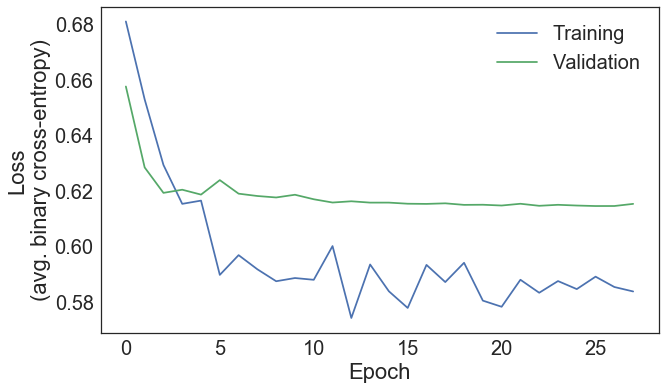

In [211]:
with mpl.rc_context(rc={"figure.figsize": (10,6)}):

    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")

    plt.legend()
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss\n(avg. binary cross-entropy)")


# 9) Look at validation results

In [212]:
class_probs = model.predict_proba(X_test_transformed).flatten()
class_probs

373/373 [==============================] - 1s 3ms/step


array([ 0.28233293,  0.29148993,  0.28947464,  0.30933291,  0.29054537,
        0.28536054,  0.30585998,  0.3123019 ,  0.29736769,  0.30830216,
        0.30670765,  0.29723209,  0.28168654,  0.29359731,  0.2991634 ,
        0.28603047,  0.28461424,  0.28366706,  0.29419401,  0.29185233,
        0.29424316,  0.28387198,  0.28235462,  0.31549552,  0.28764781,
        0.28179565,  0.29462829,  0.29919356,  0.3232266 ,  0.29607314,
        0.28676054,  0.27648339,  0.29579026,  0.29284197,  0.3003791 ,
        0.29377189,  0.28294364,  0.30551219,  0.29626894,  0.28533134,
        0.28949142,  0.30394766,  0.28582746,  0.3080501 ,  0.28228018,
        0.28375486,  0.28990874,  0.2807377 ,  0.30953714,  0.28285244,
        0.27746382,  0.29184031,  0.28689677,  0.29717284,  0.28396478,
        0.29048193,  0.28045458,  0.32470125,  0.30003086,  0.29985765,
        0.30442938,  0.3161048 ,  0.2812109 ,  0.32772458,  0.27838925,
        0.28321975,  0.28469238,  0.32409588,  0.28269136,  0.28

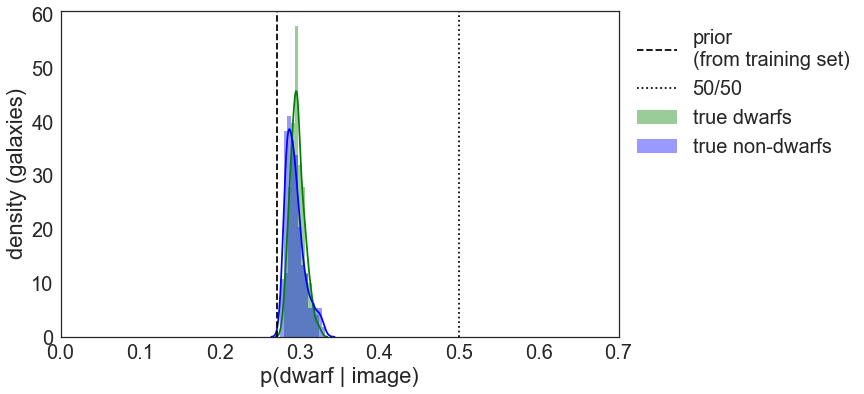

In [213]:
with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    sns.distplot(class_probs[Y[testing_set_indices]==True], color="g", label="true dwarfs")
    sns.distplot(class_probs[Y[testing_set_indices]==False], color="b", label="true non-dwarfs")

    plt.xlabel("p(dwarf | image)")
    plt.ylabel("density (galaxies)")

    plt.xlim(0, .7)
    plt.axvline(Y[training_set_indices].mean(), linestyle="dashed", color="black", label="prior\n(from training set)")
    plt.axvline(.5, linestyle="dotted", color="black", label="50/50")

    plt.legend(
        loc="upper left",
        bbox_to_anchor=(1, 1),
    )


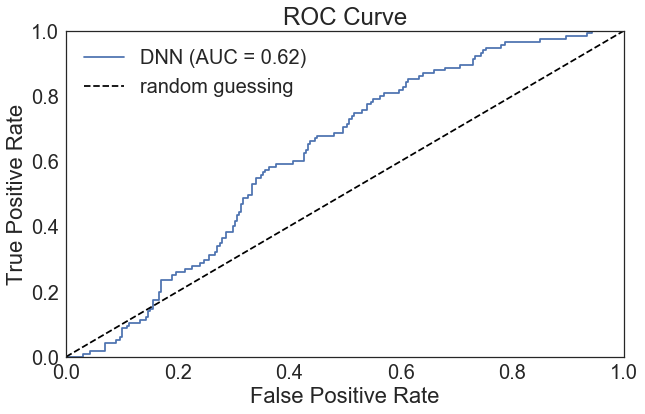

In [214]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    fpr, tpr, _ = metrics.roc_curve(Y[testing_set_indices], class_probs)
    roc_auc = roc_auc_score(Y[testing_set_indices], class_probs)

    plt.plot(fpr, tpr, label="DNN (AUC = {:.2})".format(roc_auc))
    plt.plot([0,1], [0,1], linestyle="dashed", color="black", label="random guessing")

    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.title("ROC Curve")

    plt.legend(loc="best")


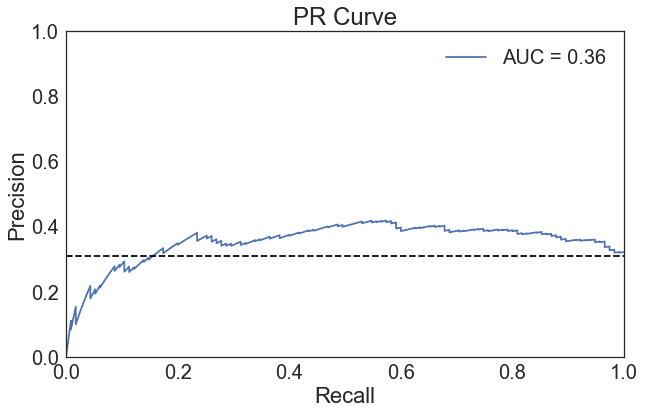

In [215]:
from sklearn.metrics import average_precision_score
with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    precision, recall, _ = metrics.precision_recall_curve(Y[testing_set_indices], class_probs)
    pr_auc = average_precision_score(Y[testing_set_indices], class_probs)

    plt.plot(recall, precision, label="AUC = {:.2}".format(pr_auc))
    plt.plot([0,1], [Y[testing_set_indices].mean()]*2, linestyle="dashed", color="black")

    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel("Recall")
    plt.ylabel("Precision")

    plt.title("PR Curve")

    plt.legend(loc="best")


## Apply a threshold
For now, just use a threshold using the prior class probability (estimated from the training set)

**Note** under a symmetric loss function, this isn't as good as 

In [153]:
predicted_classes = class_probs > (Y[training_set_indices].mean())
predicted_classes.mean()

0.32171581769436997

In [154]:
confusion_matrix = metrics.confusion_matrix(Y[testing_set_indices], predicted_classes)
confusion_matrix

array([[178,  80],
       [ 75,  40]])

In [155]:
print("number of dwarfs (true)     : ", Y[testing_set_indices].sum())
print("number of dwarfs (predicted): ", predicted_classes.sum())

number of dwarfs (true)     :  115
number of dwarfs (predicted):  120


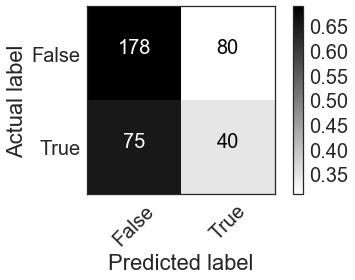

In [156]:
import itertools
# adapted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

plt.imshow(confusion_matrix_normalized, interpolation='nearest',cmap="gray_r")
# plt.title(title)
plt.colorbar()
tick_marks = np.arange(2)
classes = [False, True]
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = 1 / 2.
for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
    plt.text(j, i, format(confusion_matrix[i, j], fmt),
             fontdict={"size":20},
             horizontalalignment="center",
             color="white" if confusion_matrix_normalized[i, j] > thresh else "black")

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [157]:
print("  i - Y_true[i] - Y_pred[i] -  error?")
print("-------------------------------------")
for i in range(predicted_classes.size):
    print("{:>3} -    {:>1d}      -    {:d}      -   {:>2d}".format(i, 
                                                    Y[training_set_indices][i], 
                                                    predicted_classes[i],
                                                    (Y[training_set_indices][i] - predicted_classes[i]), 
                                                   ))

  i - Y_true[i] - Y_pred[i] -  error?
-------------------------------------
  0 -    0      -    0      -    0
  1 -    0      -    0      -    0
  2 -    1      -    0      -    1
  3 -    1      -    1      -    0
  4 -    0      -    0      -    0
  5 -    1      -    0      -    1
  6 -    0      -    1      -    1
  7 -    1      -    1      -    0
  8 -    1      -    1      -    0
  9 -    0      -    1      -    1
 10 -    1      -    0      -    1
 11 -    1      -    0      -    1
 12 -    0      -    0      -    0
 13 -    0      -    0      -    0
 14 -    1      -    0      -    1
 15 -    0      -    0      -    0
 16 -    1      -    0      -    1
 17 -    0      -    0      -    0
 18 -    0      -    0      -    0
 19 -    0      -    0      -    0
 20 -    1      -    0      -    1
 21 -    0      -    0      -    0
 22 -    1      -    0      -    1
 23 -    0      -    1      -    1
 24 -    0      -    0      -    0
 25 -    0      -    0      -    0
 26 -    0    

/Users/egentry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  import sys


# Understand my results

Uhh, so that's not very inspiring, but hopefully it'll get better when I add in more data and play around with the model architecture.

In the mean time, let's see if we can visualize the convolutional layers (working from https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)

In [71]:
# Don't go below this line for `Run All`
assert(False)

AssertionError: 

In [ ]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [ ]:
def show_filter_optimizer(filter_index):
    input_img = model.input # placeholder for actual input data

    conv_layer_output = model.layers[0].output
    loss = K.mean(conv_layer_output[:,...,filter_index])
    grads = K.gradients(loss, input_img)[0] 

    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-15)

    iterate = K.function([input_img], [loss, grads])

    
    img_width = default_image_size
    img_height = default_image_size
    input_img_data = np.random.random((1, 5, img_width, img_height)) * 20 
    step = .1

    optimization_steps = 500
    for i in range(optimization_steps):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    
    img = input_img_data[0]
    img = deprocess_image(img)
    return img
    
for i in range(16):
    plt.figure()
    img = show_filter_optimizer(i)
    plt.imshow(img[:,:,:3])
    plt.colorbar()

Huh. Not really sure what to make of that. It looks like one filter trying to mimic translational invariance?  But shouldn't my images be centered on the galaxy?  And even if there is a translational issue, why is this feature so clearly linear in one preferred direction?

In [ ]:
c = model.layers[0]

w1 = c.weights[0]

In [ ]:
v = w1.value()

In [ ]:
v

In [ ]:
w = c.get_weights()

In [ ]:
len(w)

In [ ]:
w[0].shape

In [ ]:
w[1].shape

In [ ]:
w[1]

## Show the convolution kernels, not just the argmax inputs

In [ ]:
for i in range(16):
    plt.figure()
    
    filter_number = i
    plt.imshow(w[0][:,...,0,filter_number] + w[1][filter_number]/(4*4))
    plt.colorbar()

These probably aren't very well constrained. But at least in their current form, they definitely aren't interpretable. (And it's even worse if you try to colorize them)